# Lab 3: Convolutional Neural Nets (CNNs)

## Example: CNN Implementation

## Assignment: LeNet5 Implementation - Solution

##### __1. Implement LeNet in PyTorch with tanh activation and Adam Optimizer,  achieve greater than 95% accuracy on the MNIST classification task.__
Done. Achieved a Test Accuracy = 0.987500.

 

##### __2. What values did you use for following hyperparameters when training LeNet that meets the accuracy requirement?__

__1) Learning Rate__<br />
Learning Rate = 0.001

__2) Batch Size__
I used the following batch sizes:<br /> 
Training batch size = 50 
Testing Batch Size  = 40 

__3) Dropout (if any) after your convolutional layers__ <br />
I did not use any dropout

__4) Any other hyperparameters you set manually (regularization, normalization, etc.)__ <br />
Used adam optimizer. Also used batch normalization

__3. Please plot the first 10 test images with a title that shows the probability of the predicted class.__ <br />
The plotted images are availabe below as required.



In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

train_batch_size = 50 #Define train batch size
test_batch_size  = 40 #Define test batch size (can be larger than train batch size)


# Use the following code to load and normalize the dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./Lab4/Assignment_Lab4_Attempt/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Pad(2),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=train_batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./Lab4/Assignment_Lab4_Attempt/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Pad(2),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=test_batch_size, shuffle=True)

In [2]:
list(train_loader)[0][0].size()

torch.Size([50, 1, 32, 32])

In [50]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        #define LeNet5
        self.C1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6), 
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
            )
        self.C2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2) 
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=400, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        #Define forward pass
        x = self.C1(input)
        x = self.C2(x)
        x = x.reshape(x.size(0), -1)
        logits = self.classifier(x)
        probs = self.softmax(logits)
        return logits, probs   #can also return probabilities
                        #by performing softmax




In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5(10).to(device)

learning_rate = 0.001
#Setting the loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
epochs = 5

In [52]:
train_accuracy = []
train_loss_array = []
for epoch in range(epochs):
  model.train()
  train_sample_counts = 0
  epoch_corrects = 0   
  train_loss = 0.0
  for x_train, y_train in train_loader:
      x_train, y_train = x_train.to(device), y_train.to(device) 
      y_train_predict, _ = model(x_train)
      loss = criterion(y_train_predict, y_train)  # Output of model = (logits, probits)
      optimizer.zero_grad() # reset the gradients 
      loss.backward() # compute backpropagation
      optimizer.step() # perform parameter update
      with torch.no_grad():
        _, predictions = torch.max(y_train_predict, 1)
        
        epoch_corrects += (predictions == y_train).sum()
        train_sample_counts += x_train.size(0)
        train_loss += loss.item() * x_train.size(0)
  epoch_accuracy = epoch_corrects/train_sample_counts
  train_accuracy.append(epoch_accuracy)
  train_loss_epoch = train_loss/train_sample_counts
  train_loss_array.append(train_loss_epoch)
  print()
  print(f'Epoch: {epoch} \tTraining Loss: {train_loss_epoch:.6f} \tTraining Accuracy:  {epoch_accuracy:.6f}')





Epoch: 0 	Training Loss: 0.177379 	Training Accuracy:  0.950867

Epoch: 1 	Training Loss: 0.060330 	Training Accuracy:  0.981917

Epoch: 2 	Training Loss: 0.044864 	Training Accuracy:  0.986367

Epoch: 3 	Training Loss: 0.035081 	Training Accuracy:  0.989133

Epoch: 4 	Training Loss: 0.028859 	Training Accuracy:  0.990583


In [53]:
def test():
    model.eval()
    epoch_corrects = 0
    test_sample_counts = 0
    epoch_accuracy = 0
    for x_test, y_test in test_loader:    
        #Calculate training loss on model
        x_test, y_test = x_test.to(device), y_test.to(device)
        y_pred, _ = model(x_test) # Output of model = (logits, probits)
        loss = criterion(y_pred, y_test)
        predictions = torch.max(y_pred, 1)[1]
        epoch_corrects += (predictions == y_test).sum()
        test_sample_counts += len(y_test)

        # print(epoch)
    epoch_accuracy = epoch_corrects/test_sample_counts
    print(f'Test Accuracy:  {epoch_accuracy:.6f}')
    return epoch_accuracy
test()

Test Accuracy:  0.987500


tensor(0.9875, device='cuda:0')

Text(0.5, 0.98, 'LeNet5 - Predictions')

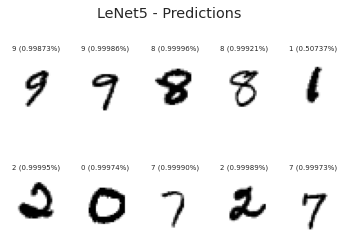

In [67]:
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid", {'axes.grid' : False})
test_x_set, _ = next(iter(test_loader))
NCols = 5
NRows = 2
fig = plt.figure()
for index in range(NCols * NRows):
    plt.subplot(NRows, NCols, index + 1)
    plt.axis("off")
    plt.imshow(test_x_set[index].squeeze().cpu(), cmap="gray_r")
    test_x_set = test_x_set.to(device)
    _, probs = model(test_x_set)
    title = f'{torch.argmax(probs[index])} ({torch.max(probs[index]):.5f}%)'
    plt.title(title, fontsize=7)
    
fig.suptitle('LeNet5 - Predictions')